# Visualisation and Analysis of Altcoins

## Structure of notebook
### Setup
- Imports and constants
- Data loading and cleaning (from csvs)

### Analysis
- Comparison at exchange level 
    - Number of coins comparison
    - Volume of trade comparison
    - Close price comparison


- Comparison at coin level
    - Shared coins across multiple exchanges and reported trade volume/price
    - Number of low-traded coins
    - Identification of spikes of trading

### Visualisation
- Graphs comparing exchanges
- Graphs comparing shared coins
- Graphs of individual coins

## Imports and Constants

In [175]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import csv
import os

In [176]:
DATA_PATH = "data"
DATA_COLLECTED = ["klines", "trades", "kline_history"]
EXCHANGES = ["huobi", "kucoin", "binance"]
EXCLUDED_COINS = ["BTCUSDT", "ETHUSDT"]

## Data Loading and Cleaning

1. Loads data from csvs to dictionaries.
2. Normalise the data between exchanges
    - Change coin names to be regular (uppercase, coin name + base coin e.g. BTCUSD)
    - Crop kline data to cover the same time period (same overall start + end time covered)#

In [177]:
huobi_col_labels = ["ts", "open", "close", "high", "low", "volume", "amount"]
kucoin_col_labels = ["start_time", "close_time", "open", "close", "high", "low", "volume"]
binance_col_labels = ["start_time", "close_time", "open", "close", "high", "low", "volume"]


In [178]:
class LoadData():
    def __init__(self, exchange, path_to_folder, metric = None, symbol = None):
        self.exchange = exchange
        self.metric = metric # if None, load all metrics
        self.symbol = symbol # if None, load all symbols
        self.path_to_folder = path_to_folder
        self.data = self.load_data()
    
    def _check_if_file_empty(self, file_path):
        """Checks if a file is empty"""
        return os.stat(file_path).st_size == 0
    
    def _add_col_labels(self, data, col_labels):
        """Adds column labels to a dataframe"""
        data.columns = col_labels
        return data

    def _load_data(self, metric, path_to_folder):
        """Loads data from csv files into a dictionary of dataframes"""
        data = {}
        if self.symbol is None:
            # for every csv file in the folder, load it into a dataframe
            for file in os.listdir("{path_to_folder}/{exchange}/{metric}".format(path_to_folder=path_to_folder, exchange=self.exchange, metric=metric)):
                # get the symbol from the csv file name
                symbol = file.split(".")[0]
                # check not empty
                if self._check_if_file_empty(f"{path_to_folder}/{self.exchange}/{metric}/{symbol}.csv"):
                    continue
                # load the csv file into a dataframe
                #print(f"Loading {symbol} {metric} data from {self.exchange}...")
                data[symbol] = pd.read_csv(f"{path_to_folder}/{self.exchange}/{metric}/{symbol}.csv")
        else:
            data[self.symbol] = pd.read_csv(f"{path_to_folder}/{metric}/{self.symbol}.csv")
        # add column labels
        if self.exchange == "huobi":
            for symbol in data:
                data[symbol] = self._add_col_labels(data[symbol], huobi_col_labels)
        elif self.exchange == "kucoin":
            for symbol in data:
                data[symbol] = self._add_col_labels(data[symbol], kucoin_col_labels)
        elif self.exchange == "binance":
            for symbol in data:
                data[symbol] = self._add_col_labels(data[symbol], binance_col_labels)
        return data


    def load_data(self, path_to_folder = None):
        """Loads data from csv files into a dictionary of dataframes"""
        if path_to_folder is None:
            path_to_folder = self.path_to_folder
        
        data = {}
        if self.metric is None:
            for metric in DATA_COLLECTED:
                data[metric] = self._load_data(metric, path_to_folder)
        else:
            data[self.metric] = self._load_data(self.metric, path_to_folder)
        return data

    def get_data(self):
        return self.data

In [179]:
class NormaliseDataFactory():
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str = None):
        self.exchange = exchange
        self.metric = metric
        self.symbol = symbol
        self.data = data
    
    def normalise_data(self):
        if self.exchange == "huobi":
            return NormaliseHuobiData(self.exchange, self.data, self.metric, self.symbol).get_normalised_data()
        elif self.exchange == "kucoin":
            return NormaliseKucoinData(self.exchange, self.data, self.metric, self.symbol).get_normalised_data()
        elif self.exchange == "binance":
            return NormaliseBinanceData(self.exchange, self.data, self.metric, self.symbol).get_normalised_data()
        else:
            raise NotImplementedError


class NormaliseData():
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        self.exchange = exchange
        self.data = data
        self.metric = metric
        self.symbol = symbol
        self.normalised_data = self.normalise_data()

    def _normalise_data(self, data: pd.DataFrame):
        pass

    def _normalise_symbol(self, symbol: str):
        pass
    
    def normalise_data(self):
        pass

    def get_normalised_data(self):
        return self.normalised_data
    
    def get_normalised_data_as_df(self):
        return pd.DataFrame(self.normalised_data)
    

class NormaliseHuobiData(NormaliseData):
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        super().__init__(exchange, data, metric, symbol)

    def normalise_data(self):
        normalised_data = {}
        for symbol in self.data.keys():
            new_symbol = self._normalise_symbol(symbol)
            normalised_data[new_symbol] = self._normalise_data(self.data[symbol])
        return normalised_data
    
    def _normalise_symbol(self, symbol: str):
        # remove kline interval from symbol
        symbol = symbol.split("_")[0]
        # uppercase symbol
        symbol = symbol.upper()
        return symbol

    def _normalise_data(self, data: pd.DataFrame):
        data.columns = huobi_col_labels

        # convert timestamp to datetime
        data["ts"] = pd.to_datetime(data["ts"], unit="ms")
        data["open"] = data["open"].astype(float)
        data["high"] = data["high"].astype(float)
        data["low"] = data["low"].astype(float)
        data["close"] = data["close"].astype(float)
        data["volume"] = data["volume"].astype(float)
        data["amount"] = data["amount"].astype(float)
        return data
    

class NormaliseKucoinData(NormaliseData):
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        super().__init__(exchange, data, metric, symbol)

    def normalise_data(self):
        normalised_data = {}
        for symbol in self.data.keys():
            new_symbol = self._normalise_symbol(symbol)
            normalised_data[new_symbol] = self._normalise_data(self.data[symbol])
        return normalised_data
    
    def _normalise_symbol(self, symbol: str):
        # remove kline interval from symbol
        symbol = symbol.split("_")[0]
        # remove hyphen
        symbol = symbol.replace("-", "")
        # uppercase symbol
        symbol = symbol.upper()
        return symbol
    
    def _normalise_data(self, data: pd.DataFrame):
        data.columns = kucoin_col_labels
        #kucoin_col_labels = ["start_time", "close_time", "open", "close", "high", "low", "volume"]

        # convert timestamp to datetime
        data["start_time"] = pd.to_datetime(data["start_time"], unit="ms")
        data["close_time"] = pd.to_datetime(data["close_time"], unit="ms")
        data["open"] = data["open"].astype(float)
        data["high"] = data["high"].astype(float)
        data["low"] = data["low"].astype(float)
        data["close"] = data["close"].astype(float)
        data["volume"] = data["volume"].astype(float)
        return data
    

class NormaliseBinanceData(NormaliseData):
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        super().__init__(exchange, data, metric, symbol)

    def normalise_data(self):
        normalised_data = {}
        for symbol in self.data.keys():
            new_symbol = self._normalise_symbol(symbol)
            normalised_data[new_symbol] = self._normalise_data(self.data[symbol])
        return normalised_data
    
    def _normalise_symbol(self, symbol: str):
        # remove kline interval from symbol
        symbol = symbol.split("_")[0]
        # remove hyphen
        symbol = symbol.replace("-", "")
        # uppercase symbol
        symbol = symbol.upper()
        return symbol
    
    def _normalise_data(self, data: pd.DataFrame):
        data.columns = binance_col_labels
        #binance_col_labels = ["start_time", "close_time", "open", "close", "high", "low", "volume"]

        # convert timestamp to datetime
        data["start_time"] = pd.to_datetime(data["start_time"], unit="ms")
        data["close_time"] = pd.to_datetime(data["close_time"], unit="ms")
        data["open"] = data["open"].astype(float)
        data["high"] = data["high"].astype(float)
        data["low"] = data["low"].astype(float)
        data["close"] = data["close"].astype(float)
        data["volume"] = data["volume"].astype(float)
        return data

time_col_by_exchange = {
    "huobi": "ts",
    "binance": "start_time",
    "kucoin": "start_time"
} # TODO MOVE 

class FilterData():
    def __init__(self):
        pass
    
    def filter_data_to_same_timeframe(self, data: dict):
        # get symbol with latest first timestamp
        # and earliest last timestamp
        """
        latest_start_time = pd.Timestamp(0)
        for exchange in data.keys():
            index = time_col_by_exchange[exchange]
            for symbol in data[exchange].keys():
                if data[exchange][symbol][index].iloc[0] > latest_start_time:
                    latest_start_time = data[exchange][symbol][index].iloc[0]
        
        earliest_end_time = pd.Timestamp.now()
        for exchange in data.keys():
            index = time_col_by_exchange[exchange]
            for symbol in data[exchange].keys():
                if data[exchange][symbol][index].iloc[-1] < earliest_end_time:
                    earliest_end_time = data[exchange][symbol][index].iloc[-1]

        # filter data to same timeframe
        for exchange in data.keys():
            index = time_col_by_exchange[exchange]
            for symbol in data[exchange].keys():
                for i, row in data[exchange][symbol].iterrows():
                    if row[index] < latest_start_time or row[index] > earliest_end_time:
                        data[exchange][symbol] = data[exchange][symbol].drop(i)
        print(data)
        """
        return data
    
    def filter_excluded_coins(self, data: dict, excluded_coins: list):
        for exchange in data.keys():
            for symbol in excluded_coins:
                if symbol in data[exchange].keys():
                    del data[exchange][symbol]
        return data



In [180]:
# Load historical kline data
huobi_data = LoadData(exchange="huobi", path_to_folder=DATA_PATH, metric="kline_history").get_data()
kucoin_data = LoadData(exchange="kucoin", path_to_folder=DATA_PATH, metric="kline_history").get_data()
binance_data = LoadData(exchange="binance", path_to_folder=DATA_PATH, metric="kline_history").get_data()

In [181]:
# Normalise data
huobi_normalised_data = NormaliseDataFactory(exchange="huobi", metric="kline_history", data=huobi_data["kline_history"]).normalise_data()
kucoin_normalised_data = NormaliseDataFactory(exchange="kucoin", metric="kline_history", data=kucoin_data["kline_history"]).normalise_data()
binance_normalised_data = NormaliseDataFactory(exchange="binance", metric="kline_history", data=binance_data["kline_history"]).normalise_data()

# Filter data to same timeframe
filtered_data = FilterData().filter_data_to_same_timeframe(data={"huobi": huobi_normalised_data, "kucoin": kucoin_normalised_data, "binance": binance_normalised_data})
huobi_filtered = filtered_data["huobi"]
kucoin_filtered = filtered_data["kucoin"]
binance_filtered = filtered_data["binance"]

# Filter excluded coins
filtered_data = FilterData().filter_excluded_coins(data={"huobi": huobi_filtered, "kucoin": kucoin_filtered, "binance": binance_filtered}, excluded_coins=EXCLUDED_COINS)

# Merge data
merged_data = {"huobi": huobi_filtered, "kucoin": kucoin_filtered, "binance": binance_filtered}




## Analysis

### Comparison of Exchanges

- Number of coins (+ shared coins)
- Volume of trade
- Close prices of coins

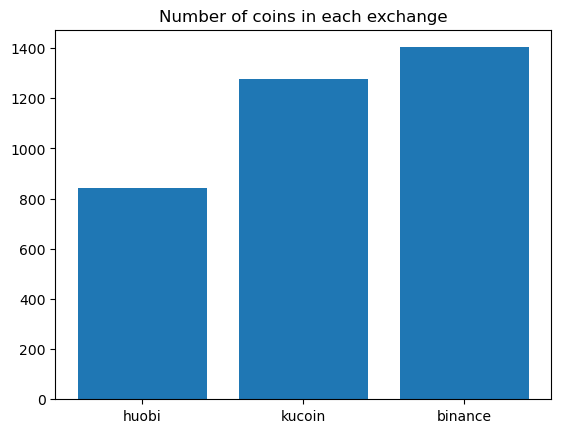

In [182]:
def plot_number_of_coins(data: list):
    """Plots the number of coins in each exchange"""
    num_exchanges = len(data)
    plt.bar(EXCHANGES, [len(data[i]) for i in range(num_exchanges)])
    plt.title("Number of coins in each exchange")
    plt.show()

list_data = list(merged_data.values())
plot_number_of_coins(list_data)

Shared coins between all three exchanges: 407


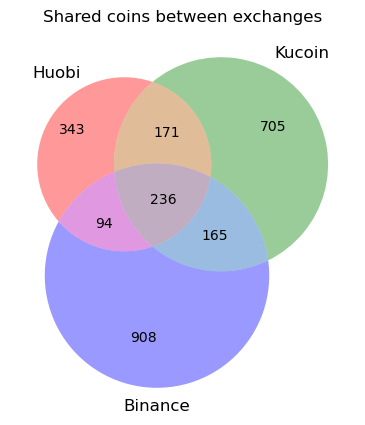

In [183]:
# Get shared coins between exchanges

def get_shared_coins(exchange_a_data: list, exchange_b_data: list):
    """Returns a list of shared coins between two exchanges"""
    shared_coins = []
    for coin in exchange_a_data.keys():
        if coin in exchange_b_data.keys():
            shared_coins.append(coin)
    return shared_coins

def get_shared_coins_between_exchanges(data: list):
    """Returns a list of shared coins between all exchanges"""
    shared_coins = []
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            shared_coins.append(get_shared_coins(data[i], data[j]))
    return shared_coins

shared_all_three = get_shared_coins_between_exchanges(list_data)
shared_huobi_kucoin = get_shared_coins(merged_data["huobi"], merged_data["kucoin"])
shared_huobi_binance = get_shared_coins(merged_data["huobi"], merged_data["binance"])
shared_kucoin_binance = get_shared_coins(merged_data["kucoin"], merged_data["binance"])

print("Shared coins between all three exchanges: {}".format(len(shared_all_three[0])))

# Venn diagram of shared coins between exchanges
plt.figure(figsize=(5, 5))
venn3([set(merged_data["huobi"]), set(merged_data["kucoin"]), set(merged_data["binance"])], set_labels = ("Huobi", "Kucoin", "Binance"))
plt.title("Shared coins between exchanges")
plt.show()

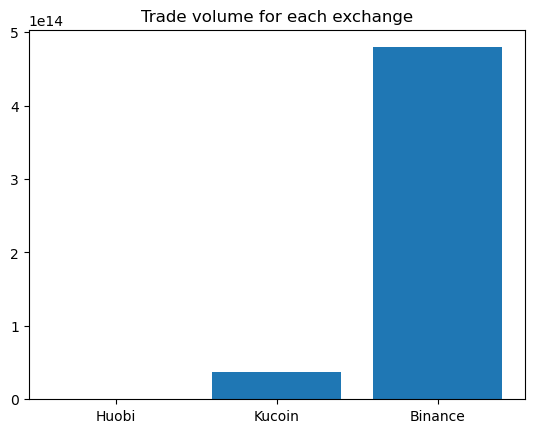

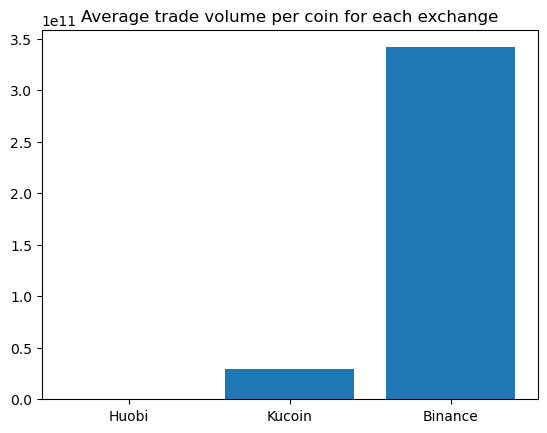

In [184]:
# Trade volume for each exchange

def get_trade_volume(data: dict):
    """Returns the trade volume of each coin"""
    trade_volume = 0
    for coin in data.keys():
        if coin not in EXCLUDED_COINS:
            trade_volume += data[coin]["volume"].sum()
    return trade_volume

huobi_trade_volume = get_trade_volume(merged_data["huobi"])
kucoin_trade_volume = get_trade_volume(merged_data["kucoin"])
binance_trade_volume = get_trade_volume(merged_data["binance"])

def plot_trade_volume(data: dict, title: str = "Trade volume for each exchange"):
    """Plots the trade volume of each coin"""
    plt.bar(data.keys(), data.values())
    plt.title(title)
    plt.show()

aggregated_vols = {"Huobi": huobi_trade_volume, "Kucoin": kucoin_trade_volume, "Binance": binance_trade_volume}
plot_trade_volume(aggregated_vols)

# Plot average trade volume per coin for each exchange
huobi_avg_vol = huobi_trade_volume / len(merged_data["huobi"])
kucoin_avg_vol = kucoin_trade_volume / len(merged_data["kucoin"])
binance_avg_vol = binance_trade_volume / len(merged_data["binance"])

avg_vols = {"Huobi": huobi_avg_vol, "Kucoin": kucoin_avg_vol, "Binance": binance_avg_vol}
plot_trade_volume(avg_vols, title="Average trade volume per coin for each exchange")

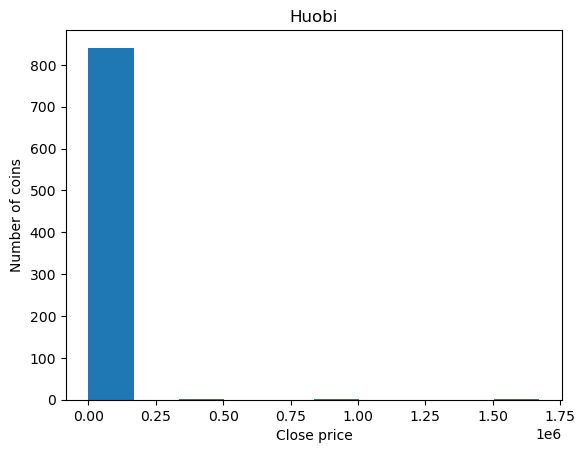

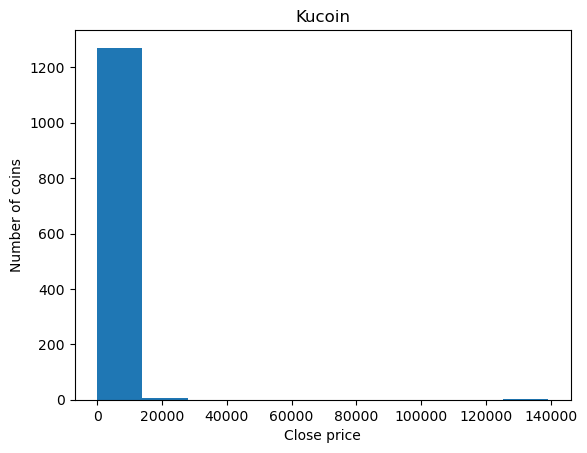

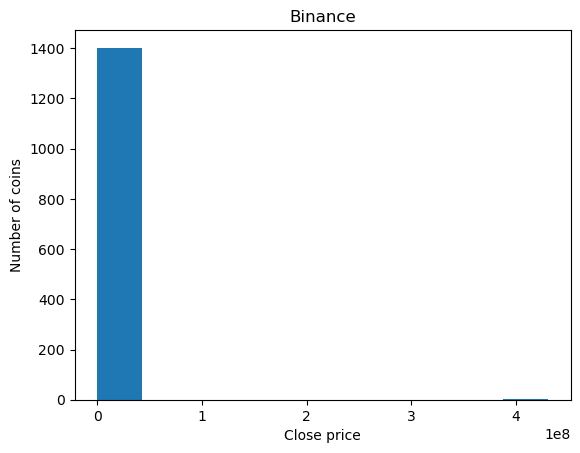

In [185]:
# Histogram of close price for each exchange

def plot_histogram(data: list, title: str = "Histogram of close price for each exchange"):
    """Plots a histogram of the close price for each coin in each exchange"""
    plt.hist(data)
    plt.title(title)
    plt.xlabel("Close price")
    plt.ylabel("Number of coins")
    
    plt.show()

huobi_close_prices = [merged_data["huobi"][coin]["close"].iloc[-1] for coin in merged_data["huobi"].keys()]
kucoin_close_prices = [merged_data["kucoin"][coin]["close"].iloc[-1] for coin in merged_data["kucoin"].keys()]
binance_close_prices = [merged_data["binance"][coin]["close"].iloc[-1] for coin in merged_data["binance"].keys()]

plot_histogram(huobi_close_prices, title="Huobi")
plot_histogram(kucoin_close_prices, title="Kucoin")
plot_histogram(binance_close_prices, title="Binance")

In [187]:
# Show more detailed histogram of close prices for very low prices
def filter_high_priced_coins(data: pd.DataFrame, threshold: float):
    # remove coins with close price over threshold
    for coin in data.keys():
        if data[coin]["close"][0] > threshold:
            pass
    

huobi_low_traded = filter_high_priced_coins(merged_data["huobi"], 1.0)
kucoin_low_traded = filter_high_priced_coins(merged_data["kucoin"], 1.0)
binance = filter_high_priced_coins(merged_data["binance"], 1.0)


1INCHBTC
1INCHUSDT
1SOLUSDT
AACUSDT
AAVEBTC
AAVEETH
AAVEUSDC
AAVEUSDT
ABBCUSDD
ABBCUSDT
ACAUSDT
ACHBTC
ACHETH
ACHUSDT
ACTUSDT
ADABTC
ADAETH
ADAUSDC
ADAUSDD
ADAUSDT
ADPUSDT
ADXUSDT
AEGISUSDT
AGIXUSDT
AGLDUSDT
AIOZUSDT
AKROUSDT
AKTUSDT
ALGOBTC
ALGOETH
ALGOUSDC
ALGOUSDT
ALICEUSDT
ALIUSDT
AMPUSDT
ANKRBTC
ANKRUSDT
ANMLUSDT
ANTBTC
ANTUSDT
ANVUSDT
APEUSDC
APEUSDD
APEUSDT
API3USDT
APTUSDC
APTUSDD
APTUSDT
AQTUSDT
ARDRBTC
ARGUSDT
ARKNUSDT
ARPABTC
ARPAUSDT
ARUSDT
ARVUSDT
ASTRUSDT
ATMUSDT
ATOMBTC
ATOMETH
ATOMUSDC
ATOMUSDD
ATOMUSDT
ATSUSDT
AUCTIONUSDT
AUDIOUSDT
AURORAUSDT
AURYUSDT
AVAXBTC
AVAXETH
AVAXUSDC
AVAXUSDD
AVAXUSDT
AXSBTC
AXSETH
AXSUSDC
AXSUSDT
AZEROUSDT
BABYDOGEUSDT
BABYUSDT
BADGERUSDT
BALUSDT
BANDUSDT
BATUSDT
BBCUSDT
BBFUSDT
BCDBTC
BCHBTC
BCHHT
BCHUSDC
BCHUSDT
BERRYUSDT
BETHETH
BETHUSDT
BICOUSDT
BITCIUSDT
BITUSDT
BIXUSDT
BLDUSDT
BLURUSDT
BLZUSDT
BNBUSDT
BNTUSDT
BOBAUSDT
BONKUSDD
BONKUSDT
BORINGUSDT
BOSONUSDT
BOXBTC
BOXUSDT
BPUSDT
BREEDUSDT
BRISEUSDT
BRTUSDT
BRWLUSDT
BSVBTC
BSVUSDC
BSVUSDT